# Common Task 1: Tokenize Squared Amplitudes

In [1]:
import numpy as np
import pandas as pd

# Read Data

In [2]:
def read_txt(path):
    with open(path,'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    text_pairs = []
    mx = 0 
    mn = 100
    x = []
    for _line in lines:
        arr = _line.split(':')
        if len(arr) == 1:
            continue
        text_pairs.append({'Event Type': arr[0], 'Feynman Diagram': arr[1], \
                           'Amplitude': arr[-2], 'Squared Amplitude': arr[-1] \
                          })
    return text_pairs

In [3]:
dir_path = '/kaggle/input/squared-amplitudes-test-data/SYMBA - Test Data/QED-2-to-2-diag-TreeLevel-'
final_pairs = []

for i in range(10):
    path = dir_path + f'{i}.txt'
    final_pairs.extend(read_txt(path))
print(f'Length of dataset: {len(final_pairs)}')

Length of dataset: 15552


In [4]:
cols = ['Event Type', 'Feynman Diagram', 'Amplitude', 'Squared Amplitude']
dtypes = { key: 'string' for key in cols}
df = pd.DataFrame(final_pairs, columns=cols)
df = df.astype(dtypes)

In [5]:
df.head(3)

,Event Type,Feynman Diagram,Amplitude,Squared Amplitude
0,Interaction,e_gam_239(X)^(*) e_del_219(X)^(*) to e_ep...,"-1/2*i*e^2*gamma_{+%\sigma_165,%gam_145,%gam_...",2*e^4*(m_e^4 + -1/2*m_e^2*s_13 + 1/2*s_14*s_2...
1,Interaction,e_gam_239(X)^(*) e_del_219(X)^(*) to e_ep...,"1/2*i*e^2*gamma_{+%\sigma_172,%gam_162,%del_1...",2*e^4*(m_e^4 + -1/2*m_e^2*s_14 + -1/2*m_e^2*s...
2,Interaction,e_gam_239(X)^(*) e_del_219(X)^(*) to e_ep...,"-1/2*i*e^2*gamma_{+%\sigma_293,%gam_358,%gam_...",2*e^4*(m_e^4 + -1/2*m_e^2*s_13 + 1/2*s_14*s_2...


In [6]:
df.iloc[0]['Amplitude']

' -1/2*i*e^2*gamma_{+%\\sigma_165,%gam_145,%gam_146}*gamma_{%\\sigma_165,%gam_147,%del_137}*e_{i_3,%gam_146}(p_1)_u*e_{k_3,%del_137}(p_2)_u*e_{l_3,%gam_145}(p_3)_u^(*)*e_{i_5,%gam_147}(p_4)_u^(*)/(m_e^2 + -s_13 + 1/2*reg_prop) '

In [7]:
df.iloc[0]['Squared Amplitude']

' 2*e^4*(m_e^4 + -1/2*m_e^2*s_13 + 1/2*s_14*s_23 + -1/2*m_e^2*s_24 + 1/2*s_12*s_34)*(m_e^2 + -s_13 + 1/2*reg_prop)^(-2)'

# Train-Test split

In [8]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
test_df.to_csv('test.csv')

Train size: 12441, Validation size: 1555, Test size: 1556


# Vocab from torchtext

As torchtext got deprecated, I have built vocab class from legacy source code. As this would be a simple and effective addition, compared to custom implementation.

In [20]:
import torch
import logging
import os
import zipfile
import gzip
from urllib.request import urlretrieve
from tqdm import tqdm
import tarfile
from functools import partial

logger = logging.getLogger(__name__)


def _infer_shape(f):
    num_lines, vector_dim = 0, None
    for line in f:
        if vector_dim is None:
            row = line.rstrip().split(b" ")
            vector = row[1:]
            # Assuming word, [vector] format
            if len(vector) > 2:
                # The header present in some (w2v) formats contains two elements.
                vector_dim = len(vector)
                num_lines += 1  # First element read
        else:
            num_lines += 1
    f.seek(0)
    return num_lines, vector_dim


def reporthook(t):
    """
    https://github.com/tqdm/tqdm.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        b: int, optional
        Number of blocks just transferred [default: 1].
        bsize: int, optional
        Size of each block (in tqdm units) [default: 1].
        tsize: int, optional
        Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

In [21]:
class Vectors(object):

    def __init__(self, name, cache=None,
                 url=None, unk_init=None, max_vectors=None):
        """
        Args:

            name: name of the file that contains the vectors
            cache: directory for cached vectors
            url: url for download if vectors not found in cache
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and returns a Tensor of the same size
            max_vectors (int): this can be used to limit the number of
                pre-trained vectors loaded.
                Most pre-trained vector sets are sorted
                in the descending order of word frequency.
                Thus, in situations where the entire set doesn't fit in memory,
                or is not needed for another reason, passing `max_vectors`
                can limit the size of the loaded set.
        """

        cache = '.vector_cache' if cache is None else cache
        self.itos = None
        self.stoi = None
        self.vectors = None
        self.dim = None
        self.unk_init = torch.Tensor.zero_ if unk_init is None else unk_init
        self.cache(name, cache, url=url, max_vectors=max_vectors)

    def __getitem__(self, token):
        if token in self.stoi:
            return self.vectors[self.stoi[token]]
        else:
            return self.unk_init(torch.Tensor(self.dim))

    def cache(self, name, cache, url=None, max_vectors=None):
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        if os.path.isfile(name):
            path = name
            if max_vectors:
                file_suffix = '_{}.pt'.format(max_vectors)
            else:
                file_suffix = '.pt'
            path_pt = os.path.join(cache, os.path.basename(name)) + file_suffix
        else:
            path = os.path.join(cache, name)
            if max_vectors:
                file_suffix = '_{}.pt'.format(max_vectors)
            else:
                file_suffix = '.pt'
            path_pt = path + file_suffix

        if not os.path.isfile(path_pt):
            if not os.path.isfile(path) and url:
                logger.info('Downloading vectors from {}'.format(url))
                if not os.path.exists(cache):
                    os.makedirs(cache)
                dest = os.path.join(cache, os.path.basename(url))
                if not os.path.isfile(dest):
                    with tqdm(unit='B', unit_scale=True, miniters=1, desc=dest) as t:
                        try:
                            urlretrieve(url, dest, reporthook=reporthook(t))
                        except KeyboardInterrupt as e:  # remove the partial zip file
                            os.remove(dest)
                            raise e
                logger.info('Extracting vectors into {}'.format(cache))
                ext = os.path.splitext(dest)[1][1:]
                if ext == 'zip':
                    with zipfile.ZipFile(dest, "r") as zf:
                        zf.extractall(cache)
                elif ext == 'gz':
                    if dest.endswith('.tar.gz'):
                        with tarfile.open(dest, 'r:gz') as tar:
                            tar.extractall(path=cache)
            if not os.path.isfile(path):
                raise RuntimeError('no vectors found at {}'.format(path))

            logger.info("Loading vectors from {}".format(path))
            ext = os.path.splitext(path)[1][1:]
            if ext == 'gz':
                open_file = gzip.open
            else:
                open_file = open

            vectors_loaded = 0
            with open_file(path, 'rb') as f:
                num_lines, dim = _infer_shape(f)
                if not max_vectors or max_vectors > num_lines:
                    max_vectors = num_lines

                itos, vectors, dim = [], torch.zeros((max_vectors, dim)), None

                for line in tqdm(f, total=max_vectors):
                    # Explicitly splitting on " " is important, so we don't
                    # get rid of Unicode non-breaking spaces in the vectors.
                    entries = line.rstrip().split(b" ")

                    word, entries = entries[0], entries[1:]
                    if dim is None and len(entries) > 1:
                        dim = len(entries)
                    elif len(entries) == 1:
                        logger.warning("Skipping token {} with 1-dimensional "
                                       "vector {}; likely a header".format(word, entries))
                        continue
                    elif dim != len(entries):
                        raise RuntimeError(
                            "Vector for token {} has {} dimensions, but previously "
                            "read vectors have {} dimensions. All vectors must have "
                            "the same number of dimensions.".format(word, len(entries),
                                                                    dim))

                    try:
                        if isinstance(word, bytes):
                            word = word.decode('utf-8')
                    except UnicodeDecodeError:
                        logger.info("Skipping non-UTF8 token {}".format(repr(word)))
                        continue

                    vectors[vectors_loaded] = torch.tensor([float(x) for x in entries])
                    vectors_loaded += 1
                    itos.append(word)

                    if vectors_loaded == max_vectors:
                        break

            self.itos = itos
            self.stoi = {word: i for i, word in enumerate(itos)}
            self.vectors = torch.Tensor(vectors).view(-1, dim)
            self.dim = dim
            logger.info('Saving vectors to {}'.format(path_pt))
            if not os.path.exists(cache):
                os.makedirs(cache)
            torch.save((self.itos, self.stoi, self.vectors, self.dim), path_pt)
        else:
            logger.info('Loading vectors from {}'.format(path_pt))
            self.itos, self.stoi, self.vectors, self.dim = torch.load(path_pt)

    def __len__(self):
        return len(self.vectors)

    def get_vecs_by_tokens(self, tokens, lower_case_backup=False):
        """Look up embedding vectors of tokens.

        Args:
            tokens: a token or a list of tokens. if `tokens` is a string,
                returns a 1-D tensor of shape `self.dim`; if `tokens` is a
                list of strings, returns a 2-D tensor of shape=(len(tokens),
                self.dim).
            lower_case_backup : Whether to look up the token in the lower case.
                If False, each token in the original case will be looked up;
                if True, each token in the original case will be looked up first,
                if not found in the keys of the property `stoi`, the token in the
                lower case will be looked up. Default: False.

        Examples:
            >>> examples = ['chip', 'baby', 'Beautiful']
            >>> vec = text.vocab.GloVe(name='6B', dim=50)
            >>> ret = vec.get_vecs_by_tokens(tokens, lower_case_backup=True)
        """
        to_reduce = False

        if not isinstance(tokens, list):
            tokens = [tokens]
            to_reduce = True

        if not lower_case_backup:
            indices = [self[token] for token in tokens]
        else:
            indices = [self[token] if token in self.stoi
                       else self[token.lower()]
                       for token in tokens]

        vecs = torch.stack(indices)
        return vecs[0] if to_reduce else vecs


In [22]:
class GloVe(Vectors):
    url = {
        '42B': 'http://nlp.stanford.edu/data/glove.42B.300d.zip',
        '840B': 'http://nlp.stanford.edu/data/glove.840B.300d.zip',
        'twitter.27B': 'http://nlp.stanford.edu/data/glove.twitter.27B.zip',
        '6B': 'http://nlp.stanford.edu/data/glove.6B.zip',
    }

    def __init__(self, name='840B', dim=300, **kwargs):
        url = self.url[name]
        name = 'glove.{}.{}d.txt'.format(name, str(dim))
        super(GloVe, self).__init__(name, url=url, **kwargs)


class FastText(Vectors):

    url_base = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.{}.vec'

    def __init__(self, language="en", **kwargs):
        url = self.url_base.format(language)
        name = os.path.basename(url)
        super(FastText, self).__init__(name, url=url, **kwargs)


class CharNGram(Vectors):

    name = 'charNgram.txt'
    url = ('http://www.logos.t.u-tokyo.ac.jp/~hassy/publications/arxiv2016jmt/'
           'jmt_pre-trained_embeddings.tar.gz')

    def __init__(self, **kwargs):
        super(CharNGram, self).__init__(self.name, url=self.url, **kwargs)

    def __getitem__(self, token):
        vector = torch.Tensor(1, self.dim).zero_()
        if token == "<unk>":
            return self.unk_init(vector)
        chars = ['#BEGIN#'] + list(token) + ['#END#']
        num_vectors = 0
        for n in [2, 3, 4]:
            end = len(chars) - n + 1
            grams = [chars[i:(i + n)] for i in range(end)]
            for gram in grams:
                gram_key = '{}gram-{}'.format(n, ''.join(gram))
                if gram_key in self.stoi:
                    vector += self.vectors[self.stoi[gram_key]]
                    num_vectors += 1
        if num_vectors > 0:
            vector /= num_vectors
        else:
            vector = self.unk_init(vector)
        return vector


pretrained_aliases = {
    "charngram.100d": partial(CharNGram),
    "fasttext.en.300d": partial(FastText, language="en"),
    "fasttext.simple.300d": partial(FastText, language="simple"),
    "glove.42B.300d": partial(GloVe, name="42B", dim="300"),
    "glove.840B.300d": partial(GloVe, name="840B", dim="300"),
    "glove.twitter.27B.25d": partial(GloVe, name="twitter.27B", dim="25"),
    "glove.twitter.27B.50d": partial(GloVe, name="twitter.27B", dim="50"),
    "glove.twitter.27B.100d": partial(GloVe, name="twitter.27B", dim="100"),
    "glove.twitter.27B.200d": partial(GloVe, name="twitter.27B", dim="200"),
    "glove.6B.50d": partial(GloVe, name="6B", dim="50"),
    "glove.6B.100d": partial(GloVe, name="6B", dim="100"),
    "glove.6B.200d": partial(GloVe, name="6B", dim="200"),
    "glove.6B.300d": partial(GloVe, name="6B", dim="300")
}
"""Mapping from string name to factory function"""


'Mapping from string name to factory function'

In [23]:
from collections import defaultdict
import logging
import torch
from tqdm import tqdm
from collections import Counter
# from torchtext.vocab import (
#     pretrained_aliases,  # not in legacy
#     Vectors,  # not in legacy
# )
from typing import List
logger = logging.getLogger(__name__)


class Vocab(object):
    """Defines a vocabulary object that will be used to numericalize a field.

    Attributes:
        freqs: A collections.Counter object holding the frequencies of tokens
            in the data used to build the Vocab.
        stoi: A collections.defaultdict instance mapping token strings to
            numerical identifiers.
        itos: A list of token strings indexed by their numerical identifiers.
    """

    # TODO (@mttk): Populate classs with default values of special symbols
    UNK = '<unk>'

    def __init__(self, counter, max_size=None, min_freq=1, specials=('<unk>', '<pad>'),
                 vectors=None, unk_init=None, vectors_cache=None, specials_first=True):
        """Create a Vocab object from a collections.Counter.

        Args:
            counter: collections.Counter object holding the frequencies of
                each value found in the data.
            max_size: The maximum size of the vocabulary, or None for no
                maximum. Default: None.
            min_freq: The minimum frequency needed to include a token in the
                vocabulary. Values less than 1 will be set to 1. Default: 1.
            specials: The list of special tokens (e.g., padding or eos) that
                will be prepended to the vocabulary. Default: ['<unk'>, '<pad>']
            vectors: One of either the available pretrained vectors
                or custom pretrained vectors (see Vocab.load_vectors);
                or a list of aforementioned vectors
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and
                returns a Tensor of the same size. Default: 'torch.zeros'
            vectors_cache: directory for cached vectors. Default: '.vector_cache'
            specials_first: Whether to add special tokens into the vocabulary at first.
                If it is False, they are added into the vocabulary at last.
                Default: True.
        """
        self.freqs = counter
        counter = counter.copy()
        min_freq = max(min_freq, 1)

        self.itos = list()
        self.unk_index = None
        if specials_first:
            self.itos = list(specials)
            # only extend max size if specials are prepended
            max_size = None if max_size is None else max_size + len(specials)

        # frequencies of special tokens are not counted when building vocabulary
        # in frequency order
        for tok in specials:
            if tok in counter:
                del counter[tok]

        # sort by frequency, then alphabetically
        words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
        words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

        for word, freq in words_and_frequencies:
            if freq < min_freq or len(self.itos) == max_size:
                break
            self.itos.append(word)

        if Vocab.UNK in specials:  # hard-coded for now
            unk_index = specials.index(Vocab.UNK)  # position in list
            # account for ordering of specials, set variable
            self.unk_index = unk_index if specials_first else len(self.itos) + unk_index
            self.stoi = defaultdict(self._default_unk_index)
        else:
            self.stoi = defaultdict()

        if not specials_first:
            self.itos.extend(list(specials))

        # stoi is simply a reverse dict for itos
        self.stoi.update({tok: i for i, tok in enumerate(self.itos)})

        self.vectors = None
        if vectors is not None:
            self.load_vectors(vectors, unk_init=unk_init, cache=vectors_cache)
        else:
            assert unk_init is None and vectors_cache is None

    def forward(self, tokens: List[str]) -> List[int]:
        return self.lookup_indices(tokens)

    def set_default_index(self, idx):
        self.unk_index = idx
        
    def _default_unk_index(self):
        return self.unk_index

    def __getitem__(self, token):
        return self.stoi.get(token, self.stoi.get(Vocab.UNK))

    def __getstate__(self):
        # avoid picking defaultdict
        attrs = dict(self.__dict__)
        # cast to regular dict
        attrs['stoi'] = dict(self.stoi)
        return attrs

    def __setstate__(self, state):
        if state.get("unk_index", None) is None:
            stoi = defaultdict()
        else:
            stoi = defaultdict(self._default_unk_index)
        stoi.update(state['stoi'])
        state['stoi'] = stoi
        self.__dict__.update(state)

    def __eq__(self, other):
        if self.freqs != other.freqs:
            return False
        if self.stoi != other.stoi:
            return False
        if self.itos != other.itos:
            return False
        if self.vectors != other.vectors:
            return False
        return True

    def __len__(self):
        return len(self.itos)

    def lookup_indices(self, tokens):
        indices = [self.__getitem__(token) for token in tokens]
        return indices

    def extend(self, v, sort=False):
        words = sorted(v.itos) if sort else v.itos
        for w in words:
            if w not in self.stoi:
                self.itos.append(w)
                self.stoi[w] = len(self.itos) - 1

    def load_vectors(self, vectors, **kwargs):
        """
        Args:
            vectors: one of or a list containing instantiations of the
                GloVe, CharNGram, or Vectors classes. Alternatively, one
                of or a list of available pretrained vectors:

                charngram.100d
                fasttext.en.300d
                fasttext.simple.300d
                glove.42B.300d
                glove.840B.300d
                glove.twitter.27B.25d
                glove.twitter.27B.50d
                glove.twitter.27B.100d
                glove.twitter.27B.200d
                glove.6B.50d
                glove.6B.100d
                glove.6B.200d
                glove.6B.300d

            Remaining keyword arguments: Passed to the constructor of Vectors classes.
        """
        if not isinstance(vectors, list):
            vectors = [vectors]
        for idx, vector in enumerate(vectors):
            if isinstance(vector, str):
                # Convert the string pretrained vector identifier
                # to a Vectors object
                if vector not in pretrained_aliases:
                    raise ValueError("Got string input vector {}, but allowed pretrained vectors are {}".format(vector, list(pretrained_aliases.keys())))
                vectors[idx] = pretrained_aliases[vector](**kwargs)
            elif not isinstance(vector, Vectors):
                raise ValueError( "Got input vectors of type {}, expected str or Vectors object".format(type(vector)))
        tot_dim = sum(v.dim for v in vectors)
        self.vectors = torch.Tensor(len(self), tot_dim)
        for i, token in enumerate(self.itos):
            start_dim = 0
            for v in vectors:
                end_dim = start_dim + v.dim
                self.vectors[i][start_dim:end_dim] = v[token.strip()]
                start_dim = end_dim
            assert(start_dim == tot_dim)

    def set_vectors(self, stoi, vectors, dim, unk_init=torch.Tensor.zero_):
        """
        Set the vectors for the Vocab instance from a collection of Tensors.

        Args:
            stoi: A dictionary of string to the index of the associated vector
                in the `vectors` input argument.
            vectors: An indexed iterable (or other structure supporting __getitem__) that
                given an input index, returns a FloatTensor representing the vector
                for the token associated with the index. For example,
                vector[stoi["string"]] should return the vector for "string".
            dim: The dimensionality of the vectors.
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and
                returns a Tensor of the same size. Default: 'torch.zeros'
        """
        self.vectors = torch.Tensor(len(self), dim)
        for i, token in enumerate(self.itos):
            wv_index = stoi.get(token, None)
            if wv_index is not None:
                self.vectors[i] = vectors[wv_index]
            else:
                self.vectors[i] = unk_init(self.vectors[i])


class SubwordVocab(Vocab):

    def __init__(self, counter, max_size=None, specials=('<pad>'),
                 vectors=None, unk_init=torch.Tensor.zero_):
        """Create a revtok subword vocabulary from a collections.Counter.

        Args:
            counter: collections.Counter object holding the frequencies of
                each word found in the data.
            max_size: The maximum size of the subword vocabulary, or None for no
                maximum. Default: None.
            specials: The list of special tokens (e.g., padding or eos) that
                will be prepended to the vocabulary in addition to an <unk>
                token.
            vectors: One of either the available pretrained vectors
                or custom pretrained vectors (see Vocab.load_vectors);
                or a list of aforementioned vectors
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and
                returns a Tensor of the same size. Default: 'torch.zeros
        """
        try:
            import revtok
        except ImportError:
            print("Please install revtok.")
            raise

        # Hardcode unk_index as subword_vocab has no specials_first argument
        self.unk_index = (specials.index(SubwordVocab.UNK)
                          if SubwordVocab.UNK in specials else None)

        if self.unk_index is None:
            self.stoi = defaultdict()
        else:
            self.stoi = defaultdict(self._default_unk_index)

        self.stoi.update({tok: i for i, tok in enumerate(specials)})
        self.itos = specials.copy()

        self.segment = revtok.SubwordSegmenter(counter, max_size)

        max_size = None if max_size is None else max_size + len(self.itos)

        # sort by frequency/entropy, then alphabetically
        toks = sorted(self.segment.vocab.items(), key=lambda tup: (len(tup[0]) != 1, -tup[1], tup[0]))

        for tok, _ in toks:
            if len(self.itos) == max_size:
                break
            self.itos.append(tok)
            self.stoi[tok] = len(self.itos) - 1

        if vectors is not None:
            self.load_vectors(vectors, unk_init=unk_init)


# Tokenizer

In [9]:
from collections import Counter, OrderedDict
from itertools import cycle
import re
import random
from tqdm import tqdm
import warnings

class Tokenizer:
    """
    Tokenizer for processing symbolic mathematical expressions.
    """
    def __init__(self, df, index_token_pool_size, momentum_token_pool_size, special_symbols, UNK_IDX, to_replace):
        self.amps = df.Amplitude.tolist()
        self.sqamps = df['Squared Amplitude'].tolist()

        # Generate token pools
        self.tokens_pool = [f"_{i}" for i in range(index_token_pool_size)]
        self.momentum_pool = [f"MOMENTUM_{i}" for i in range(momentum_token_pool_size)]
        
        # Regular expression patterns for token replacement
        self.pattern_momentum = re.compile(r'\b[p]_\d{1,}\b')
        self.pattern_num_123 = re.compile(r'\b(?![ps]_)\w+_\d{1,}\b')
        self.pattern_special = re.compile(r'\b\w+_+\w+\b\\')
        self.pattern_prop = re.compile(r'Prop')
        self.pattern_int = re.compile(r'int\{')
        self.pattern_operators = {
            '+': re.compile(r'\+'), '-': re.compile(r'-'), '*': re.compile(r'\*'),
            ',': re.compile(r','), '^': re.compile(r'\^'), '%': re.compile(r'%'),
            '}': re.compile(r'\}'), '(': re.compile(r'\('), ')': re.compile(r'\)')
        }
        self.function_opening = re.compile(r'(\w+_\{)')
        self.pattern_mass = re.compile(r'\b\w+_\w\b')
        self.pattern_s = re.compile(r'\b\w+_\d{2,}\b')
        self.pattern_reg_prop = re.compile(r'\b\w+_\d{1}\b')
        self.pattern_antipart = re.compile(r'(\w)_\w+_\d+\(X\)\^\(\*\)')
        self.pattern_part = re.compile(r'(\w)_\w+_\d+\(X\)')
        self.pattern_index = re.compile(r'\b\w+_\w+_\d{2,}\b')
        
        self.special_symbols = special_symbols
        self.UNK_IDX = UNK_IDX
        self.to_replace = to_replace

    @staticmethod
    def remove_whitespace(expression):
        """Remove all forms of whitespace from the expression."""
        return re.sub(r'\s+', '', expression)

    @staticmethod
    def split_expression(expression):
        """Split the expression by space delimiter."""
        return re.split(r' ', expression)

    def build_tgt_vocab(self):
        """Build vocabulary for target sequences."""
        counter = Counter()
        for eqn in tqdm(self.sqamps, desc='Processing target vocab'):
            counter.update(self.tgt_tokenize(eqn))
        voc = Vocab(OrderedDict(counter), specials=self.special_symbols[:], specials_first=True)
        voc.set_default_index(self.UNK_IDX)
        return voc

    def build_src_vocab(self, seed):
        """Build vocabulary for source sequences."""
        counter = Counter()
        for diag in tqdm(self.amps, desc='Processing source vocab'):
            counter.update(self.src_tokenize(diag, seed))
        voc = Vocab(OrderedDict(counter), specials=self.special_symbols[:], specials_first=True)
        voc.set_default_index(self.UNK_IDX)
        return voc
    
    def src_replace(self, ampl, seed):
        """Replace indexed and momentum variables with tokenized equivalents."""
        ampl = self.remove_whitespace(ampl)
        
        random.seed(seed)
        token_cycle = cycle(random.sample(self.tokens_pool, len(self.tokens_pool)))
        momentum_cycle = cycle(random.sample(self.momentum_pool, len(self.momentum_pool)))
        
        # Replace momentum tokens
        temp_ampl = ampl
        momentum_mapping = {match: next(momentum_cycle) for match in set(self.pattern_momentum.findall(ampl))}
        for key, value in momentum_mapping.items():
            temp_ampl = temp_ampl.replace(key, value)


        def replace_123_match(match):
            word, num = match.group().rsplit('_', 1)
            return f"{word}_INDEX_{next(token_cycle)}"
        temp_ampl = re.sub(self.pattern_num_123,replace_123_match,ampl)
        return temp_ampl
    
    def src_tokenize(self, ampl, seed):
        """Tokenize source expression, optionally applying replacements."""
        temp_ampl = self.src_replace(ampl, seed) if self.to_replace else ampl
        temp_ampl = temp_ampl.replace('\\\\', '\\').replace('\\', ' \\ ').replace('%', '')
        
        for symbol, pattern in self.pattern_operators.items():
            temp_ampl = pattern.sub(f' {symbol} ', temp_ampl)

        temp_ampl = self.function_opening.sub(r'\1 ', temp_ampl)
        
        temp_ampl = re.sub(r' {2,}', ' ', temp_ampl)
        return [token for token in self.split_expression(temp_ampl) if token]

    def tgt_tokenize(self, sqampl):
        """Tokenize target expression."""
        sqampl = self.remove_whitespace(sqampl)
        temp_sqampl = sqampl
        
        for symbol, pattern in self.pattern_operators.items():
            temp_sqampl = pattern.sub(f' {symbol} ', temp_sqampl)
        
        for pattern in [self.pattern_reg_prop, self.pattern_mass, self.pattern_s]:
            temp_sqampl = pattern.sub(lambda match: f' {match.group(0)} ', temp_sqampl)
        
        temp_sqampl = re.sub(r' {2,}', ' ', temp_sqampl)
        return [token for token in self.split_expression(temp_sqampl) if token]

In [10]:
BOS_IDX, PAD_IDX, EOS_IDX, UNK_IDX, SEP_IDX = 0, 1, 2, 3, 4
special_symbols = ['<S>', '<PAD>', '</S>', '<UNK>', '<SEP>']
dummy_tokenizer = Tokenizer(train_df, 500, 500, special_symbols, UNK_IDX, False)

In [12]:
def normalize_indices(tokenizer, expressions, index_token_pool_size=50, momentum_token_pool_size=50):
    # Function to replace indices with a new set of tokens for each expression
    def replace_indices(token_list, index_map):
        new_index = (f"{i}" for i in range(index_token_pool_size))  # Local generator for new indices
        new_tokens = []
        for token in token_list:
            if "INDEX_" in token:
                if token not in index_map:
                    try:
                        index_map[token] = token.rsplit('_',1)[0] + next(new_index)
                    except StopIteration:
                        # Handle the case where no more indices are available
                        raise ValueError("Ran out of unique indices, increase token_pool_size")
                new_tokens.append(index_map[token])
            else:
                new_tokens.append(token)
        return new_tokens
    def replace_momenta(token_list, index_map):
        new_index = (f"MOMENTUM_{i}" for i in range(momentum_token_pool_size))  # Local generator for new indices
        new_tokens = []
        for token in token_list:
            if "MOMENTUM_" in token:
                if token not in index_map:
                    try:
                        index_map[token] = next(new_index)
                    except StopIteration:
                        # Handle the case where no more indices are available
                        raise ValueError("Ran out of unique indices, increase momentum_token_pool_size")
                new_tokens.append(index_map[token])
            else:
                new_tokens.append(token)
        return new_tokens


    normalized_expressions = []
    # Replace indices in each expression randomly
    for expr in tqdm(expressions,desc="Normalizing.."):
        toks = tokenizer.src_tokenize(expr,42)
        normalized_expressions.append(replace_momenta(replace_indices(toks, {}), {}))

    return normalized_expressions

In [13]:
def aug_data(df):
    # Extract columns
    amps = df['Amplitude']
    sqamps = df['Squared Amplitude']

    # Data augmentation
    n_samples = 1 #args.n_samples
    aug_amps = []

    for amp in tqdm(amps, desc='processing'):
        random_seed = [random.randint(1, 1000) for _ in range(n_samples)]
        for seed in random_seed:
            aug_amps.append(dummy_tokenizer.src_replace(amp, seed))
    aug_sqamps = [sqamp for sqamp in sqamps for _ in range(n_samples)]

    if True:
        normal_amps = normalize_indices(dummy_tokenizer, aug_amps, 500, 500)
        aug_amps = []
        for amp in normal_amps:
            aug_amps.append("".join(amp))

    # Create augmented DataFrame
    df_aug = pd.DataFrame({"Amplitude": aug_amps, "Squared Amplitude": aug_sqamps})

    return df_aug


In [14]:
train_df_aug = aug_data(train_df)
val_df_aug = aug_data(val_df)
test_df_aug = aug_data(test_df)

Normalizing..: 100%|██████████| 1556/1556 [00:00<00:00, 4776.66it/s]


In [15]:
train_df_aug.to_csv('train.csv')
val_df_aug.to_csv('valid.csv')
test_df_aug.to_csv('test.csv')

In [16]:
len(pd.read_csv('train.csv'))

12441

In [25]:
# train_df_aug['Amplitude'][10]

In [17]:
tokenizer = Tokenizer(train_df_aug, 500, 500, special_symbols, UNK_IDX, False)

In [25]:
src_vocab = tokenizer.build_src_vocab(42)
tgt_vocab = tokenizer.build_tgt_vocab()

Processing target vocab: 100%|██████████| 12441/12441 [00:01<00:00, 6698.02it/s]


In [38]:
print('Source vocab size: ',len(src_vocab), ' \nTarget Vocab size:', len(tgt_vocab))

Source vocab size:  459  
Target Vocab size: 59


In [29]:
from tqdm.auto import tqdm
aln = []
sln = []
for idx,row in tqdm(train_df_aug.iterrows(),total=len(train_df_aug)):
    aln.append(len(tokenizer.src_tokenize(row['Amplitude'],seed=42)))
    sln.append(len(tokenizer.tgt_tokenize(row['Squared Amplitude'])))

  0%|          | 0/12441 [00:00<?, ?it/s]

In [30]:
!pip install -q matplotlib==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 74.0 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


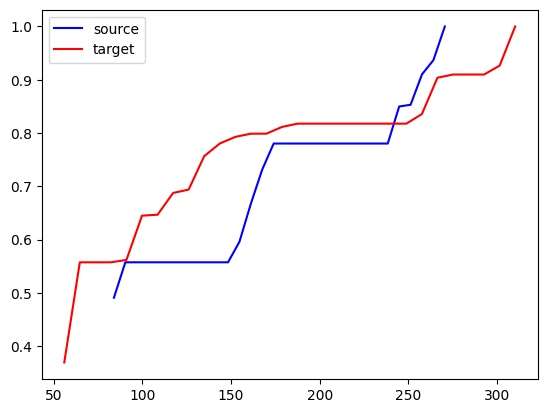

In [31]:
import numpy as np
import matplotlib.pyplot as plt

ahist, abase = np.histogram(aln, bins=30)
acum = np.cumsum(ahist)
plt.plot(abase[:-1], acum/len(aln), c='blue', label='source')
shist, sbase = np.histogram(sln, bins=30)
scum = np.cumsum(shist)
plt.plot(sbase[:-1], scum/len(sln), c='red', label='target')
plt.legend()

In [35]:
print(tokenizer.src_tokenize(train_df_aug['Amplitude'][10],seed=42))

['-', '1/6', '*', 'i', '*', 'e', '^', '2', '*', 'gamma_{', '+', '\\', 'tau_INDEX_0', ',', 'eta_INDEX_1', ',', 'alpha_INDEX_2', '}', '*', 'gamma_{', '\\', 'tau_INDEX_3', ',', 'gam_INDEX_4', ',', 'del_INDEX_5', '}', '*', 'b_{', 'j_INDEX_6', ',', 'gam_INDEX_7', '}', '(', 'p_4', ')', '_u', '^', '(', '*', ')', '*', 'b_{', 'i_INDEX_8', ',', 'del_INDEX_9', '}', '(', 'p_3', ')', '_v', '*', 'mu_{', 'k_INDEX_10', ',', 'alpha_INDEX_11', '}', '(', 'p_1', ')', '_u', '*', 'mu_{', 'l_INDEX_12', ',', 'eta_INDEX_13', '}', '(', 'p_2', ')', '_v', '^', '(', '*', ')', '/', '(', 'm_mu', '^', '2', '+', 's_12', '+', '1/2', '*', 'reg_prop', ')']
